In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os

# For scaling
from sklearn.preprocessing import RobustScaler

# For separation and sampling
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [37]:
# 1. Loading data

# Download via kagglehub
path_folder = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
csv_file = [f for f in os.listdir(path_folder) if f.endswith('.csv')][0]
full_path = os.path.join(path_folder, csv_file)
df = pd.read_csv(full_path)

print(f"Total Transactions : {len(df)}")
print(f"Fraud : {len(df[df['Class'] == 1])}")

Using Colab cache for faster access to the 'creditcardfraud' dataset.
Total Transactions : 284807
Fraud : 492


In [38]:
# 2. Scaling of the 'Amount' and 'Time' columns
rob_scaler = RobustScaler() # I use RobustScaler because it is less sensitive to outliers than StandardScaler.

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

# The old Time and Amount columns are deleted.
df.drop(['Time', 'Amount'], axis=1, inplace=True)

# The scaled columns are placed at the beginning
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)


In [39]:
# 3. Separation of variables (X) and target (y)
X = df.drop('Class', axis=1)
y = df['Class']

# Split Train/Test with 'stratify' to maintain the proportion of fraud
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# SMOTE application only on the TRAIN set
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print(f"After SMOTE, the training set has {len(y_train_res)} transactions.")

After SMOTE, the training set has 454902 transactions.


In [40]:
# 4. Model setup
model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

# Training
model.fit(X_train_res, y_train_res)

# Prediction
y_pred = model.predict(X_test)

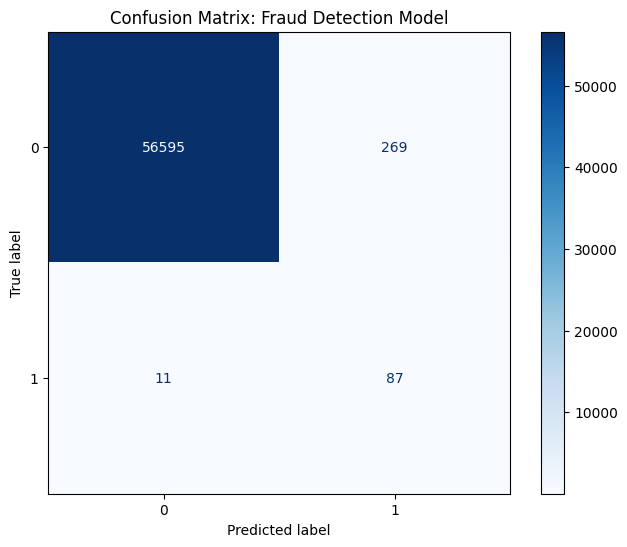


--- Performance Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.24      0.89      0.38        98

    accuracy                           1.00     56962
   macro avg       0.62      0.94      0.69     56962
weighted avg       1.00      1.00      1.00     56962



In [41]:
# 5. Displaying the confusion matrix visually
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap='Blues')
plt.title('Confusion Matrix: Fraud Detection Model')
plt.show()

# Full report: Focus on RECALL for Class 1
print("\n--- Performance Report ---")
print(classification_report(y_test, y_pred))

/tmp/ipython-input-2540667554.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')


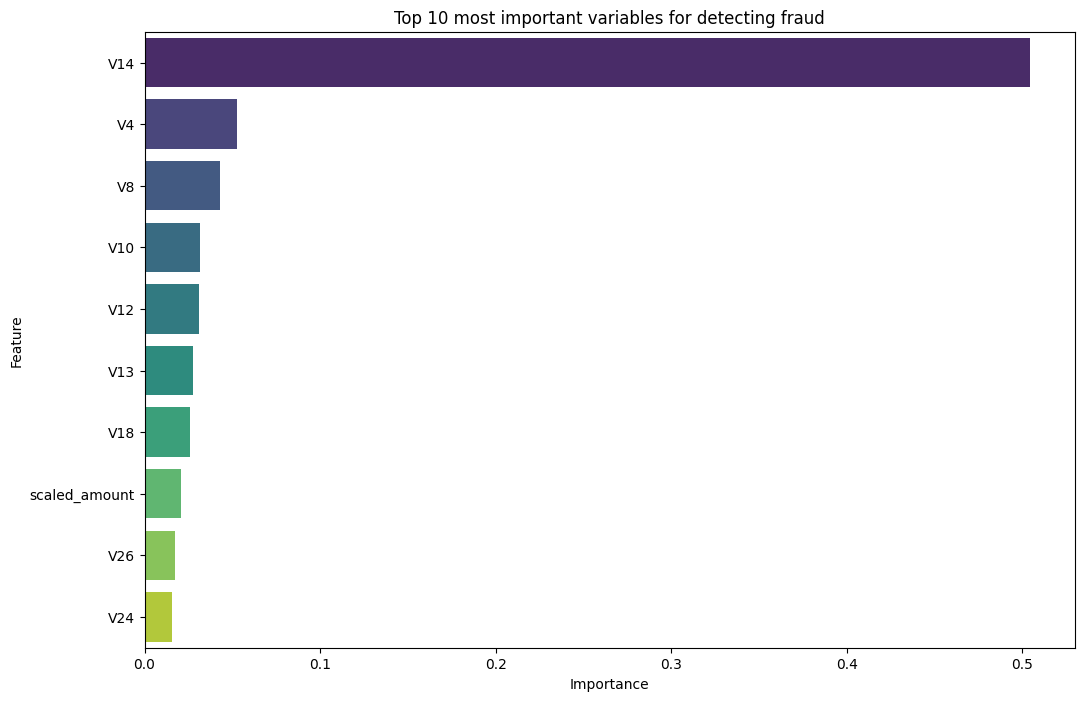

In [42]:
# 6. Extracting the importance of variables
importances = model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Visualization
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')
plt.title('Top 10 most important variables for detecting fraud')
plt.show()